
<h1 style="text-align: center;">NFL Combine Cornerback Build-Up</h1>
<p style="text-align: center;"><em>Exploratory Analysis and Predictive Modeling Using NCAA and Combine Metrics</em></p>

---

### 📘 Strategic Context

This notebook provides a structured analysis of NFL cornerback prospects based on NFL Combine and Draft data across the 2015-2021 drafts. The objective is to identify patterns, segment athletes by physical and performance profiles, and forecast draft outcomes using classification models.

This type of applied analysis mirrors techniques used in:

- **Performance forecasting and simulation**
- **Data-driven personnel evaluation**
- **Talent planning and segmentation**

The approach is relevant to both sports analytics and human performance modeling environments.


## 🔹 1. Setup and Imports

In [1]:
!pip install kmodes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.neural_network import MLPClassifier
from IPython.display import display
import os
os.environ['THREADPOOLCTL_SKIP_BLAS_VENDOR_CHECK'] = '1'
import warnings
warnings.filterwarnings('ignore')

## 🔹 2. Load and Inspect Data

In [2]:
# Load your dataset
df = pd.read_excel('Cornerback Data_NCAA 2015_Combine.xlsx')

# Preview the data
df.head()

,Draft Year,Name,Round,Pick Number,NFL Team,College,Conference,Height (in),Weight (lb),Arm Length (in),Hand Span (in),40-Yard Dash (sec),20-Yard Shuttle (sec),3-Cone Drill (sec),Vertical Jump (in),Broad Jump (in),Bench Press (reps)
0,2015,Trae Waynes,1,11,Vikings,Michigan State,Big10,72.125,186.0,31.000,8.250,4.31,4.18,7.06,38.0,122.0,19.0
1,2015,Kevin Johnson,1,16,Texans,Wake Forrest,ACC,72.250,188.0,31.000,8.375,4.52,3.89,6.79,41.5,130.0,NaN
2,2015,Marcus Peters,1,18,Chiefs,Washington,Pac12,71.625,197.0,31.500,8.375,4.53,4.08,7.08,37.5,121.0,17.0
3,2015,Byron Jones,1,27,Cowboys,Uconn,The American,72.625,199.0,32.000,10.000,4.43,3.94,6.78,44.5,147.0,18.0
4,2015,Jalen Collins,2,42,Falcons,LSU,SEC,73.500,203.0,32.125,9.375,4.48,4.27,6.77,36.0,124.0,NaN


In [3]:
df.dtypes

Draft Year                 int64
Name                      object
Round                      int64
Pick Number                int64
NFL Team                  object
College                   object
Conference                object
Height (in)              float64
Weight (lb)              float64
Arm Length (in)          float64
Hand Span (in)           float64
40-Yard Dash (sec)       float64
20-Yard Shuttle (sec)    float64
3-Cone Drill (sec)       float64
Vertical Jump (in)       float64
Broad Jump (in)          float64
Bench Press (reps)       float64
dtype: object

In [4]:
# List combine and measurement features to be used
combine_features = ['40-Yard Dash (sec)', '20-Yard Shuttle (sec)', '3-Cone Drill (sec)', 'Vertical Jump (in)', 'Broad Jump (in)', 'Bench Press (reps)']
measurements = ['Height (in)', 'Weight (lb)', 'Arm Length (in)', 'Hand Span (in)']
features = combine_features + measurements

In [5]:
# Confirm missing values
df[features].isnull().sum()

40-Yard Dash (sec)       33
20-Yard Shuttle (sec)    65
3-Cone Drill (sec)       64
Vertical Jump (in)       44
Broad Jump (in)          45
Bench Press (reps)       54
Height (in)              21
Weight (lb)              21
Arm Length (in)          29
Hand Span (in)           29
dtype: int64

## 🔹 3. Median Imputation by Round

In [6]:
# Copy original for imputation
df_imputed = df.copy()

# Median imputation per round for each feature
for col in features:
    df_imputed[col] = df_imputed.groupby('Round')[col].transform(lambda x: x.fillna(x.median()))

# Store pre-imputation stats
pre_stats_by_round = df.groupby('Round')[features].describe(percentiles=[0.25, 0.5, 0.75]).round(2)
pre_stats_all = df[features].describe(percentiles=[0.25, 0.5, 0.75]).round(2)

# Store post-imputation stats
post_stats_by_round = df_imputed.groupby('Round')[features].describe(percentiles=[0.25, 0.5, 0.75]).round(2)
post_stats_all = df_imputed[features].describe(percentiles=[0.25, 0.5, 0.75]).round(2)


In [7]:
# Show summaries

print("Pre-Imputation Stats (Entire Sample):")
display(pre_stats_all)

print("\n Post-Imputation Stats (Entire Sample):")
display(post_stats_all)

Pre-Imputation Stats (Entire Sample):


,40-Yard Dash (sec),20-Yard Shuttle (sec),3-Cone Drill (sec),Vertical Jump (in),Broad Jump (in),Bench Press (reps),Height (in),Weight (lb),Arm Length (in),Hand Span (in)
count,188.00,156.00,157.00,177.00,176.00,167.00,200.00,200.00,192.00,192.00
mean,4.46,4.20,6.94,36.67,124.56,14.88,71.58,194.15,31.35,9.10
std,0.08,0.14,0.17,2.85,5.76,4.03,1.71,8.79,1.00,0.43
min,4.28,3.82,6.45,29.50,114.00,5.00,60.25,170.00,28.75,8.00
25%,4.41,4.12,6.84,34.50,120.00,12.00,70.38,188.00,30.62,8.75
50%,4.46,4.19,6.94,36.50,124.00,15.00,71.62,193.00,31.38,9.12
75%,4.51,4.28,7.06,38.50,128.25,17.00,72.62,200.00,32.00,9.38
max,4.69,4.57,7.65,44.50,147.00,26.00,76.25,220.00,34.00,10.25



 Post-Imputation Stats (Entire Sample):


,40-Yard Dash (sec),20-Yard Shuttle (sec),3-Cone Drill (sec),Vertical Jump (in),Broad Jump (in),Bench Press (reps),Height (in),Weight (lb),Arm Length (in),Hand Span (in)
count,221.00,221.00,221.00,221.00,221.00,221.00,221.00,221.00,221.00,221.00
mean,4.46,4.20,6.95,36.63,124.29,14.86,71.55,193.99,31.31,9.09
std,0.07,0.12,0.15,2.59,5.23,3.51,1.64,8.39,0.94,0.40
min,4.28,3.82,6.45,29.50,114.00,5.00,60.25,170.00,28.75,8.00
25%,4.42,4.14,6.88,35.00,121.00,13.00,70.62,189.00,30.75,8.88
50%,4.47,4.20,6.94,36.50,123.50,15.00,71.50,193.00,31.25,9.00
75%,4.50,4.27,7.03,38.50,127.00,17.00,72.50,199.00,31.88,9.38
max,4.69,4.57,7.65,44.50,147.00,26.00,76.25,220.00,34.00,10.25


### 📉 Pre and Post Imputation Stats by Round

Pre- and post-imputation summary statistics by draft round were also generated for each combine and body measurement feature. However, these detailed tables are not included here due to their dense format, which does not translate well to a notebook viewer layout.

These tables remain available in the working environment.


## 🔹 4. Pre/Post Imputation Boxplots

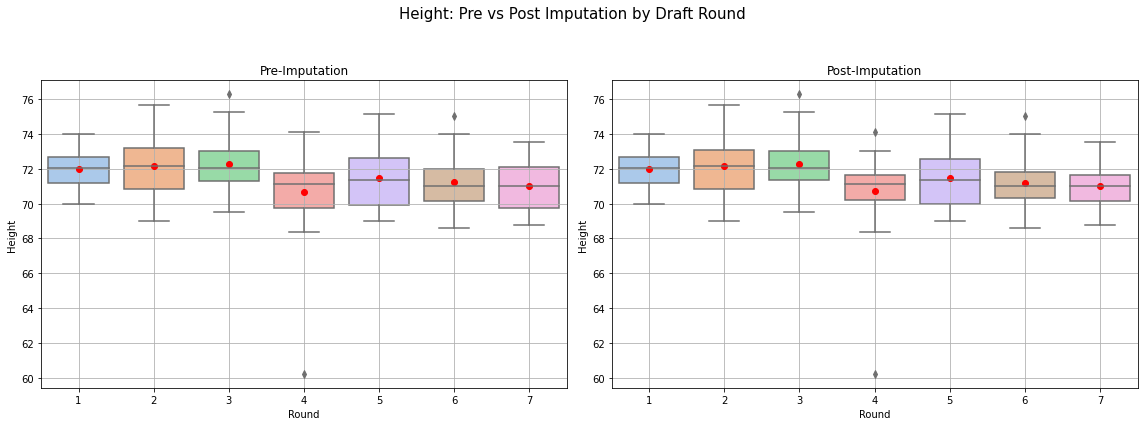

In [8]:
# Height Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("Height: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='Height (in)', data=df, palette='pastel')
means = df.groupby('Round')['Height (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("Height")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='Height (in)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['Height (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("Height")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


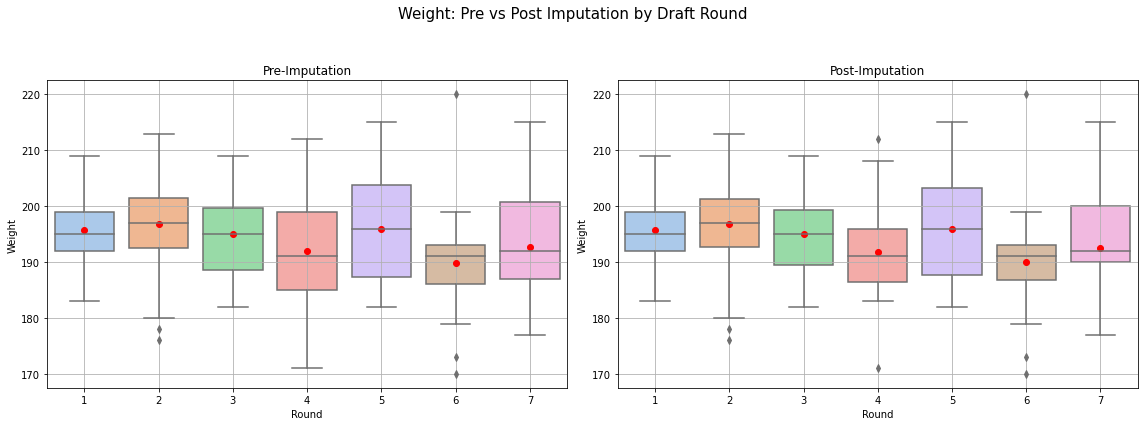

In [9]:
# Weight Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("Weight: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='Weight (lb)', data=df, palette='pastel')
means = df.groupby('Round')['Weight (lb)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("Weight")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='Weight (lb)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['Weight (lb)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("Weight")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

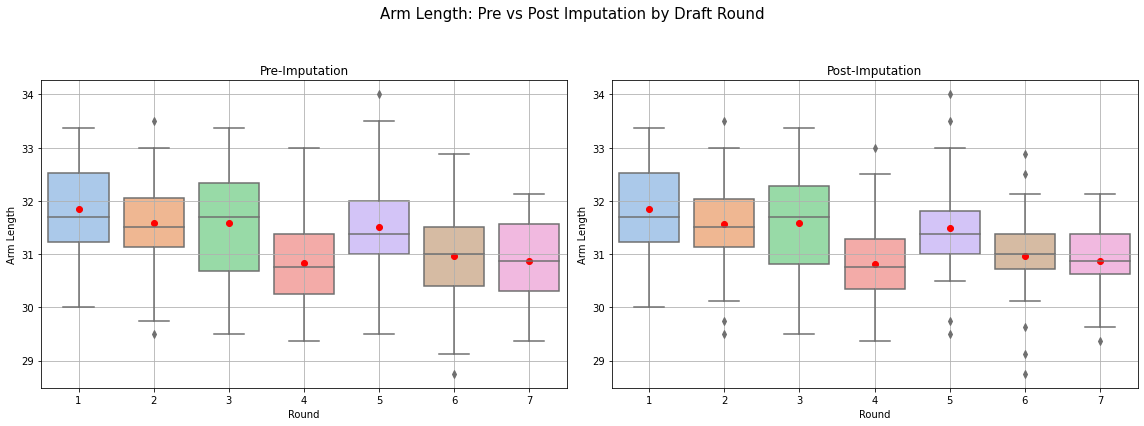

In [10]:
# Arm Length Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("Arm Length: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='Arm Length (in)', data=df, palette='pastel')
means = df.groupby('Round')['Arm Length (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("Arm Length")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='Arm Length (in)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['Arm Length (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("Arm Length")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

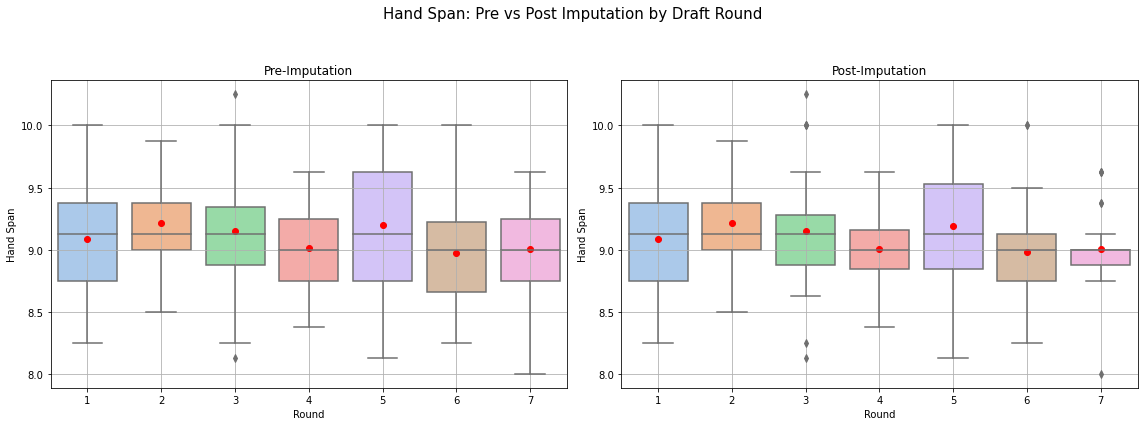

In [11]:
# Hand Span Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("Hand Span: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='Hand Span (in)', data=df, palette='pastel')
means = df.groupby('Round')['Hand Span (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("Hand Span")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='Hand Span (in)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['Hand Span (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("Hand Span")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

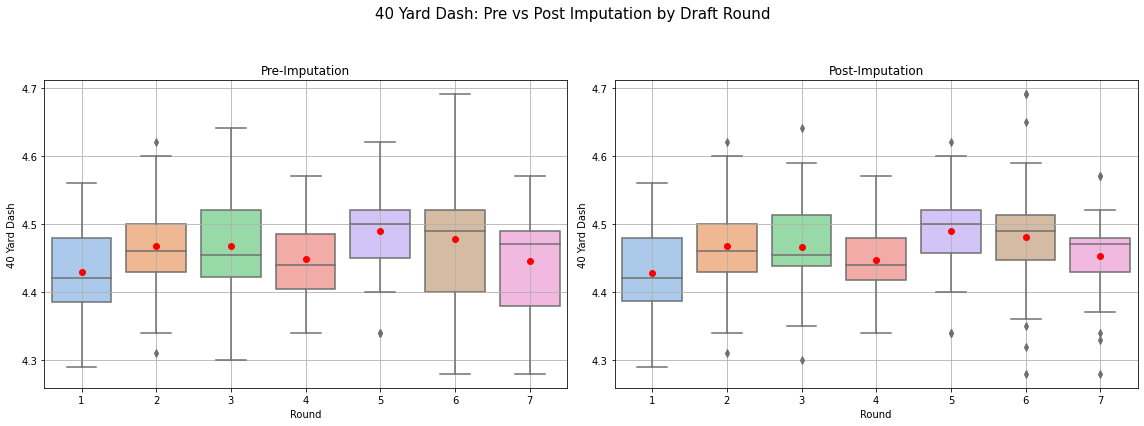

In [12]:
# 40 Yard Dash Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("40 Yard Dash: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='40-Yard Dash (sec)', data=df, palette='pastel')
means = df.groupby('Round')['40-Yard Dash (sec)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("40 Yard Dash")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='40-Yard Dash (sec)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['40-Yard Dash (sec)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("40 Yard Dash")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

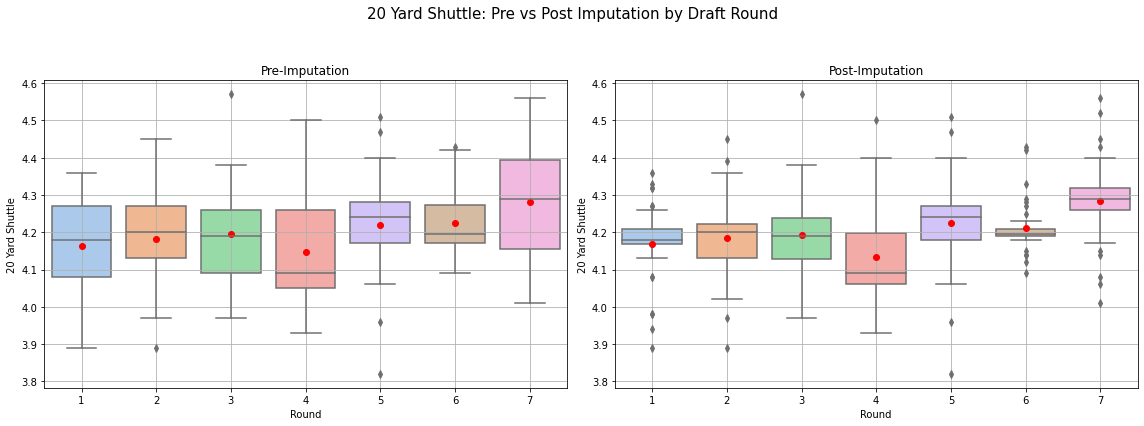

In [13]:
# 20 Yard Shuttle Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("20 Yard Shuttle: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='20-Yard Shuttle (sec)', data=df, palette='pastel')
means = df.groupby('Round')['20-Yard Shuttle (sec)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("20 Yard Shuttle")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='20-Yard Shuttle (sec)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['20-Yard Shuttle (sec)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("20 Yard Shuttle")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

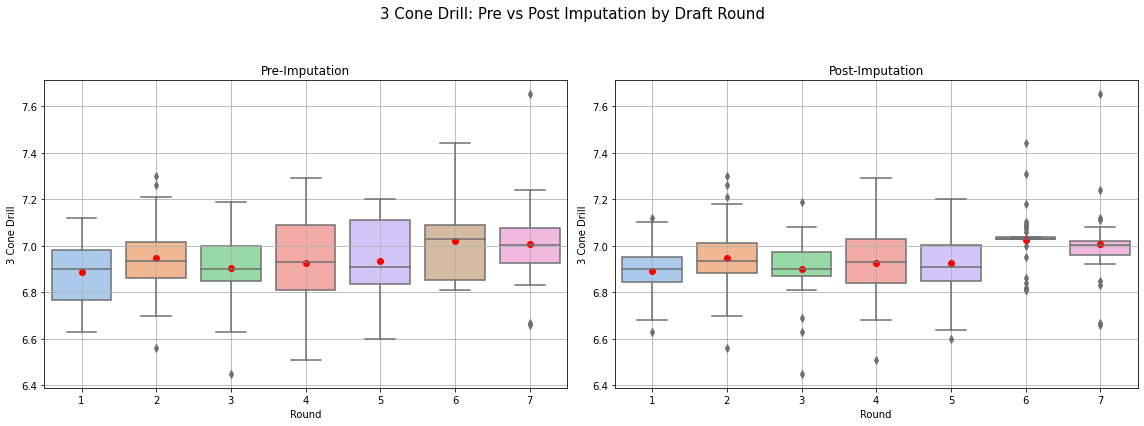

In [14]:
# 3 Cone Drill Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("3 Cone Drill: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='3-Cone Drill (sec)', data=df, palette='pastel')
means = df.groupby('Round')['3-Cone Drill (sec)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("3 Cone Drill")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='3-Cone Drill (sec)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['3-Cone Drill (sec)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("3 Cone Drill")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

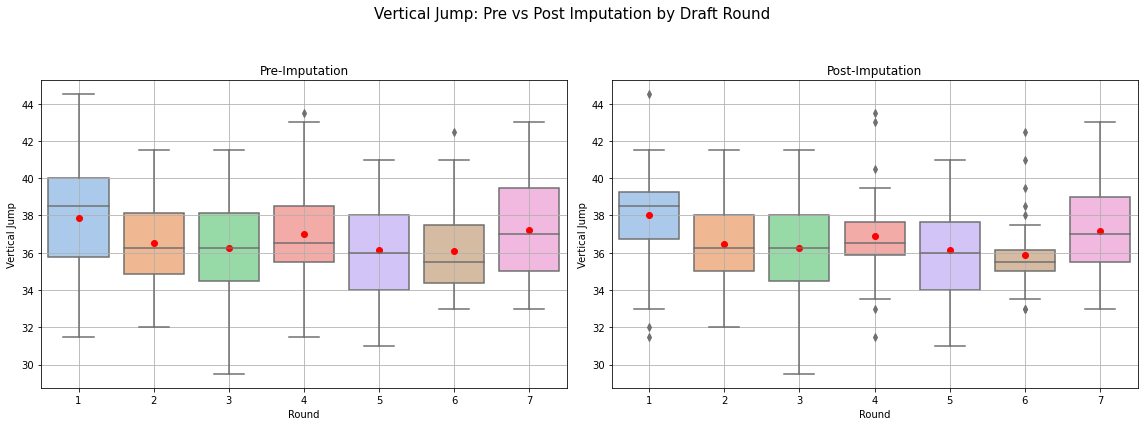

In [15]:
# Vertical Jump Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("Vertical Jump: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='Vertical Jump (in)', data=df, palette='pastel')
means = df.groupby('Round')['Vertical Jump (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("Vertical Jump")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='Vertical Jump (in)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['Vertical Jump (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("Vertical Jump")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

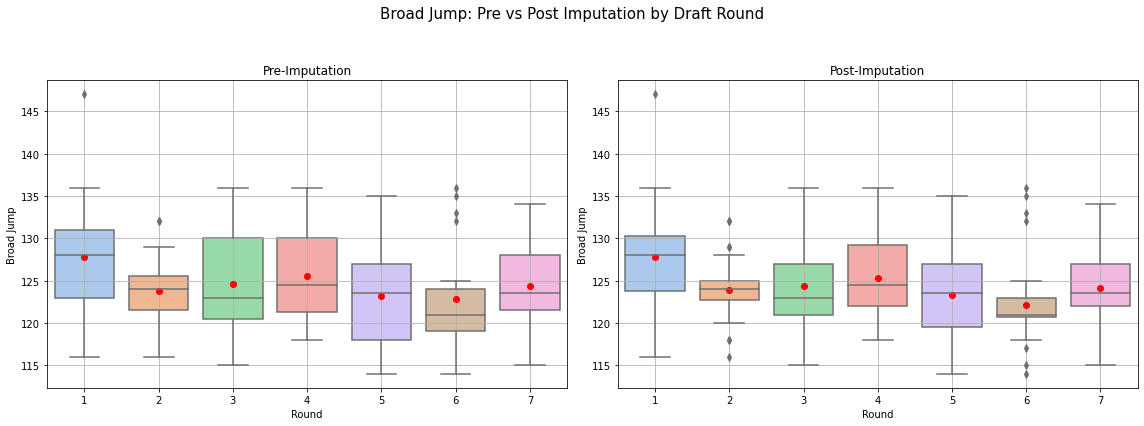

In [16]:
# Broad Jump Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("Broad Jump: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='Broad Jump (in)', data=df, palette='pastel')
means = df.groupby('Round')['Broad Jump (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("Broad Jump")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='Broad Jump (in)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['Broad Jump (in)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("Broad Jump")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

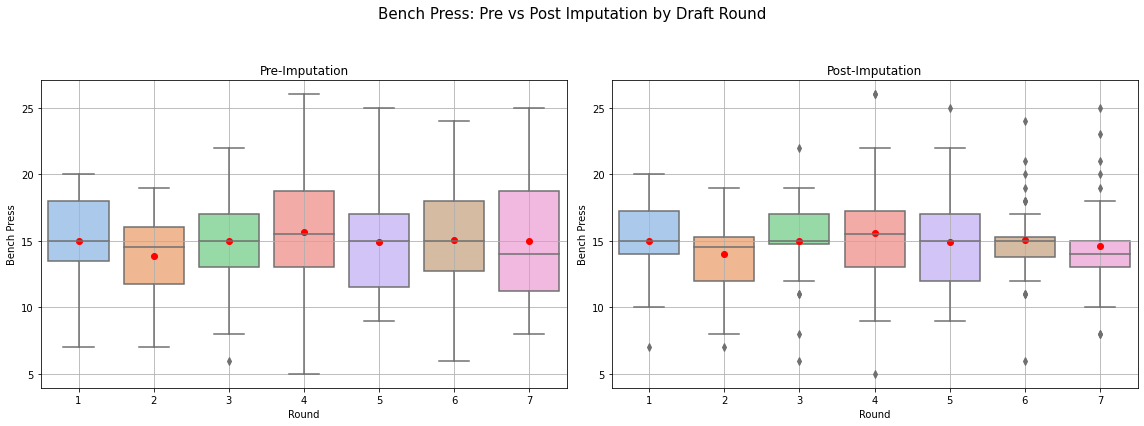

In [17]:
# Bench Press Pre and Post Imputation Boxplots
plt.figure(figsize=(16, 6))
plt.suptitle("Bench Press: Pre vs Post Imputation by Draft Round", fontsize=15)

plt.subplot(1, 2, 1)
sns.boxplot(x='Round', y='Bench Press (reps)', data=df, palette='pastel')
means = df.groupby('Round')['Bench Press (reps)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Pre-Imputation")
plt.xlabel("Round")
plt.ylabel("Bench Press")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x='Round', y='Bench Press (reps)', data=df_imputed, palette='pastel')
means = df_imputed.groupby('Round')['Bench Press (reps)'].mean()
for i, mean in enumerate(means):
    plt.plot(i, mean, 'o', color='red')
plt.title("Post-Imputation")
plt.xlabel("Round")
plt.ylabel("Bench Press")
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## 🔹 5. Clustering (K-Means and K-Prototypes)

### Note on Elbow Method Omission:
The Elbow Method is a commonly used technique to determine the optimal number of clusters for K-Means. I initially planned to include it in this project to empirically select the best number of clusters based on inertia. However, due to a system-level error related to the OpenBLAS backend on macOS—specifically a NoneType error when accessing threadpool metadata—I was unable to execute this step within my current environment.

For both K-Means and K-Prototypes clustering, the number of clusters was set to seven, aligning with the seven rounds of the NFL Draft. This domain-driven approach assumes each cluster may correspond to the skill, athletic profile, or perceived value associated with a particular draft round.

### 5.1. K-Means Clustering

In [18]:
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed[features])

# Fit KMeans
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Display cluster_centers
kmeans_centers_original = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features
)
kmeans_centers_original.index.name = 'Cluster'

# Display the result
print("K-Means Cluster Centers (Original Scale):")
display(kmeans_centers_original)

K-Means Cluster Centers (Original Scale):


,40-Yard Dash (sec),20-Yard Shuttle (sec),3-Cone Drill (sec),Vertical Jump (in),Broad Jump (in),Bench Press (reps),Height (in),Weight (lb),Arm Length (in),Hand Span (in)
Cluster,,,,,,,,,,
0,4.424167,4.205667,6.926833,35.341667,120.816667,13.650000,69.612500,183.266667,30.275000,8.791667
1,4.415500,4.287500,7.073000,35.225000,124.150000,18.775000,72.325000,200.100000,31.582500,8.862500
2,4.504194,4.155968,6.872581,36.387097,124.112903,14.403226,73.395161,202.354839,32.588710,9.483871
3,4.459474,4.080000,6.873158,38.157895,125.921053,15.710526,71.233553,194.578947,31.049342,8.953947
4,4.494643,4.246929,6.974571,35.460714,121.650000,14.050000,71.241071,191.857143,31.057143,9.107143
5,4.527500,4.487500,7.392500,33.875000,122.000000,7.250000,73.093750,182.000000,31.468750,9.218750
6,4.411786,4.190714,6.938571,40.535714,133.000000,15.785714,71.991071,198.107143,31.785714,9.281250


### Interpretation of K-Means Cluster Centers

The seven clusters correspond to groups of cornerback prospects with similar athletic profiles, potentially aligning with different draft strategies or prospect archetypes. Key takeaways:

- **Cluster 6** stands out with the **highest vertical jump (40.5 in)** and **broad jump (133 in)**, suggesting explosive athletes—possibly those targeted for top rounds due to raw athleticism.
- **Cluster 3** shows strong all-around athleticism with solid agility scores and vertical/broad jump, making them balanced prospects.
- **Cluster 2** includes players with **larger frames** (highest height, weight, arm, and hand size) and strong jumps, possibly representing press-man or hybrid CBs with measurables that appeal to physical playstyles.
- **Cluster 5** contains the **slowest agility scores (7.39s 3-cone)** and **lowest bench (7.25 reps)**, possibly representing late-round or undrafted prospects.
- **Cluster 1** has the **highest bench press average (18.8 reps)** and a solid frame, possibly appealing to teams valuing strength and size at the position.


### 5.2. K-Prototypes Clustering

In [19]:
# Prepare data with draft round as categorical
df_proto = df_imputed[['Round'] + features].dropna()
proto_data = df_proto.copy()
proto_data['Round'] = proto_data['Round'].astype(str)
X_proto = proto_data.values

# KPrototypes clustering
kproto = KPrototypes(n_clusters=7, init='Huang', random_state=42)
clusters_proto = kproto.fit_predict(X_proto, categorical=[0])
df_imputed.loc[df_proto.index, 'kproto_cluster'] = clusters_proto

### Note on Omitting K-Prototypes Cluster Centroids: 

I attempted to display the cluster centers for the K-Prototypes model by separating and inverse-scaling the numerical features while preserving the categorical centroids. However, a dimensional mismatch error occurred during the inverse transformation step. This issue is likely due to shape misalignment or unintended mixing of feature types. I am currently troubleshooting the environment and code logic to properly recover and interpret the centroids. Once resolved, I will update the notebook to display the cluster centers in their original scale.

## 🔹 6. Logistic Regression and Multi-Layer Perceptron to Predict Draft Round

### 6.1. Logistic Regression

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           1       0.32      0.36      0.34        28
           2       0.21      0.25      0.23        36
           3       0.10      0.06      0.08        32
           4       0.25      0.14      0.18        28
           5       0.12      0.09      0.11        32
           6       0.40      0.58      0.47        36
           7       0.38      0.41      0.39        29

    accuracy                           0.28       221
   macro avg       0.25      0.27      0.26       221
weighted avg       0.25      0.28      0.26       221


Per-Round Performance:
               precision    recall  f1-score
1              0.322581  0.357143  0.338983
2              0.209302  0.250000  0.227848
3              0.095238  0.062500  0.075472
4              0.250000  0.142857  0.181818
5              0.120000  0.093750  0.105263
6              0.396226  0.583333  0.471910
7              0.375

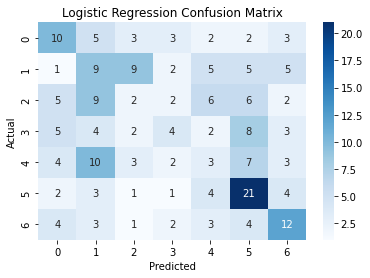

In [24]:
# Prepare features and target
X = df_imputed[features]
y = df_imputed.loc[X.index, 'Round']

# Logistic Regression with 10-fold cross-validation
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred = cross_val_predict(lr, X, y, cv=cv)

# Metrics
print("Logistic Regression Classification Report")
print(classification_report(y, y_pred))

# Per-round accuracy, precision, recall
report = pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T
print("\nPer-Round Performance:\n", report[['precision', 'recall', 'f1-score']])

# Confusion matrix
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Fit logistic regression on full dataset for later simulation
lr.fit(X, y)

# Save predictions
df_imputed.loc[X.index, 'lr_pred_round'] = y_pred

### 6.2. Multi-Layer Perceptron

=== MLP Classification Report ===
              precision    recall  f1-score   support

           1       0.22      0.14      0.17        28
           2       0.17      0.33      0.23        36
           3       0.00      0.00      0.00        32
           4       0.29      0.29      0.29        28
           5       0.10      0.06      0.08        32
           6       0.32      0.50      0.39        36
           7       0.14      0.07      0.09        29

    accuracy                           0.21       221
   macro avg       0.18      0.20      0.18       221
weighted avg       0.18      0.21      0.18       221


Per-Round Performance:
               precision    recall  f1-score
1              0.222222  0.142857  0.173913
2              0.173913  0.333333  0.228571
3              0.000000  0.000000  0.000000
4              0.285714  0.285714  0.285714
5              0.100000  0.062500  0.076923
6              0.315789  0.500000  0.387097
7              0.142857  0.068966  0

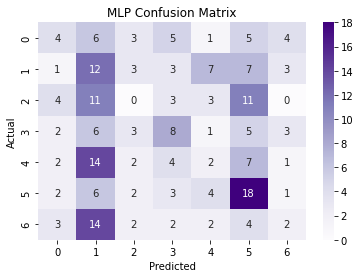

In [21]:
# Prepare features and target
X_nn = df_imputed[features]
y_nn = df_imputed.loc[X.index, 'Round']

# Neural Network (Multi-Layer Perceptron) with 10-fold cross-validation
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
y_nn_pred = cross_val_predict(mlp, X_nn, y_nn, cv=cv)

# Metrics
print("MLP Classification Report")
print(classification_report(y_nn, y_nn_pred))

# Per-round accuracy, precision, recall
nn_report = pd.DataFrame(classification_report(y_nn, y_nn_pred, output_dict=True)).T
print("\nPer-Round Performance:\n", nn_report[['precision', 'recall', 'f1-score']])

# Confusion matrix
sns.heatmap(confusion_matrix(y_nn, y_nn_pred), annot=True, fmt='d', cmap='Purples')
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save predictions
df_imputed.loc[X_nn.index, 'nn_pred_round'] = y_nn_pred

### MLP Evaluation

The confusion matrix and classification report indicate that the MLP struggled to classify cornerbacks into their correct NFL draft rounds. The model achieved an overall **accuracy of ~21%**, suggesting weak predictive performance.

**Key Observations:**
- **Round 6** had the strongest results: **18 correct predictions**, with the highest **recall (0.50)** and **f1-score (0.39)**. The model was most effective at identifying players drafted in this round.
- **Round 3** had **zero correct predictions**, consistent with its **precision, recall, and f1-score of 0.00**. This suggests the model is not learning distinguishable patterns for this class.
- **Rounds 2 and 4** showed slightly better performance, with modest f1-scores (**0.23 and 0.29**, respectively), but still reflect significant misclassification.
- **Rounds 1, 5, and 7** performed poorly across all metrics, with low precision, recall, and f1-scores, indicating the model has difficulty separating these classes from others.
- The confusion matrix shows heavy misclassification across nearly all classes, implying that the model's learned representations are not sufficiently separating the draft rounds.

**Next Steps:**
- Improve feature selection or transformation to enhance separability between rounds.
- Try **resampling techniques** if class imbalance is a factor.
- Consider **model architecture tuning** or using more expressive models (e.g., ensembles or deeper networks).
- Add regularization or dropout to address overfitting if training accuracy is high but test performance is low.


## 🔹 7. Simulation: Trait-Based Draft Probabilities

Please enter your values for the following Combine and measurement features:
40-Yard Dash (sec): 4.3
20-Yard Shuttle (sec): 4.5
3-Cone Drill (sec): 6.5
Vertical Jump (in): 30
Broad Jump (in): 120
Bench Press (reps): 15
Height (in): 72
Weight (lb): 190
Arm Length (in): 34
Hand Span (in): 10


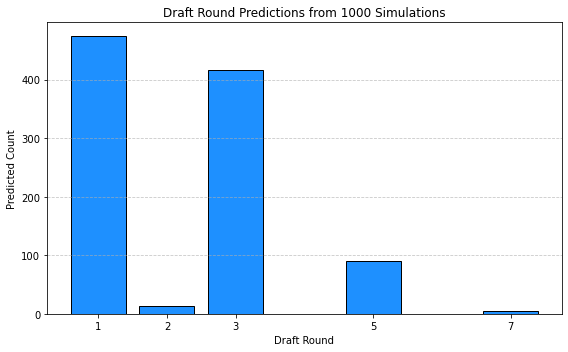

Draft Round Prediction Probabilities:


,Round,Predicted Picks,Probability (%)
0,1,474,47.4
1,2,14,1.4
2,3,417,41.7
3,5,91,9.1
4,7,4,0.4


In [25]:
# 1. Prompt user for inputs
print("Please enter your values for the following Combine and measurement features:")
user_values = {
    "40-Yard Dash (sec)": float(input("40-Yard Dash (sec): ")),
    "20-Yard Shuttle (sec)": float(input("20-Yard Shuttle (sec): ")),
    "3-Cone Drill (sec)": float(input("3-Cone Drill (sec): ")),
    "Vertical Jump (in)": float(input("Vertical Jump (in): ")),
    "Broad Jump (in)": float(input("Broad Jump (in): ")),
    "Bench Press (reps)": float(input("Bench Press (reps): ")),
    "Height (in)": float(input("Height (in): ")),
    "Weight (lb)": float(input("Weight (lb): ")),
    "Arm Length (in)": float(input("Arm Length (in): ")),
    "Hand Span (in)": float(input("Hand Span (in): "))
}

# 2. Convert to DataFrame.
user_input = pd.DataFrame([user_values])

# 3. Scale user input using fitted scaler.
user_scaled = scaler.transform(user_input)

# 4. Run 1000 simulations using logistic regression predicted probabilities.
simulations = 1000
probs = lr.predict_proba(user_scaled)[0]
classes = lr.classes_
predictions = np.random.choice(classes, size=simulations, p=probs)

# 5. Count results and calculate probabilities.
prediction_counts = pd.Series(predictions).value_counts().sort_index()
rounds = sorted(prediction_counts.index.tolist())
counts = [prediction_counts.get(r, 0) for r in rounds]
probabilities = [round(count / simulations * 100, 2) for count in counts]

# 6. Plot bar chart of simulation results.
plt.figure(figsize=(8, 5))
plt.bar(rounds, counts, color='dodgerblue', edgecolor='black')
plt.xlabel("Draft Round")
plt.ylabel("Predicted Count")
plt.title("Draft Round Predictions from 1000 Simulations")
plt.xticks(rounds)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 7. Display results as DataFrame.
simulation_df = pd.DataFrame({
    "Round": rounds,
    "Predicted Picks": counts,
    "Probability (%)": probabilities
})

print("Draft Round Prediction Probabilities:")
display(simulation_df)
